# Plot the M_ZAMS distribution of the different metallicities for all potential DCO systems

In [53]:
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import os
import sys

# add run_data path to sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02"# "v02.46.01/"#v02.35.02/"
sim_name =  'NewWinds_RemFryer2012' #'OldWinds_RemFryer2012'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  

datar_root = f"{home_dir}/ceph/CompasOutput/{compas_v}"

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)



# Read pre-constructed data

## Split your potential DCO table between potential BBH, BHNS and NSNS

Happens in [ DataManipulation notebook](./DataManipulation.ipynb)

In [56]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(f'{datar_root}/{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)

with h5.File(f'{datar_root}/{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]


    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560052 entries, 0 to 560051
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SEED                                  560052 non-null  uint64 
 1   Metallicity@ZAMS(1)                   560052 non-null  float64
 2   Stellar_Type(1)                       560052 non-null  int32  
 3   Stellar_Type(2)                       560052 non-null  int32  
 4   CE_Event_Counter                      560052 non-null  uint32 
 5   Mass@ZAMS(1)                          560052 non-null  float64
 6   Mass@ZAMS(2)                          560052 non-null  float64
 7   SemiMajorAxis@ZAMS                    560052 non-null  float64
 8   Merger                                560052 non-null  uint8  
 9   Merger_At_Birth                       560052 non-null  uint8  
 10  Unbound                               560052 non-null  uint8  
 11  

In [57]:
def DCO_merger_bool(table, flavor = 'BBH'):
    """return the DCO merger bool for a given flavor

    Args:
        pandas table: containing all potential DCOs (incl. things that don't become DCO at specific Z)
        flavor (str, optional): BBH, BHNS, or NNSNS 
    """
    BBH_bool = np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 14)
    BHNS_bool = np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 14),
                            np.logical_and(table['Stellar_Type(1)'] == 14,table['Stellar_Type(2)'] == 13) )
    NSNS_bool = np.logical_and(table['Stellar_Type(1)'] == 13,table['Stellar_Type(2)'] == 13)
    if flavor == 'BBH':
        return np.logical_and(BBH_bool,table['Merges_Hubble_Time'] == True)
    elif flavor == 'BHNS':  
        return np.logical_and(BHNS_bool,table['Merges_Hubble_Time'] == True)
    elif flavor == 'NSNS':
        return np.logical_and(NSNS_bool,table['Merges_Hubble_Time'] == True)
    

BBH
len(table) 54242
BHNS
len(table) 314
NSNS
len(table) 160
error, probably empty group 0.03 1


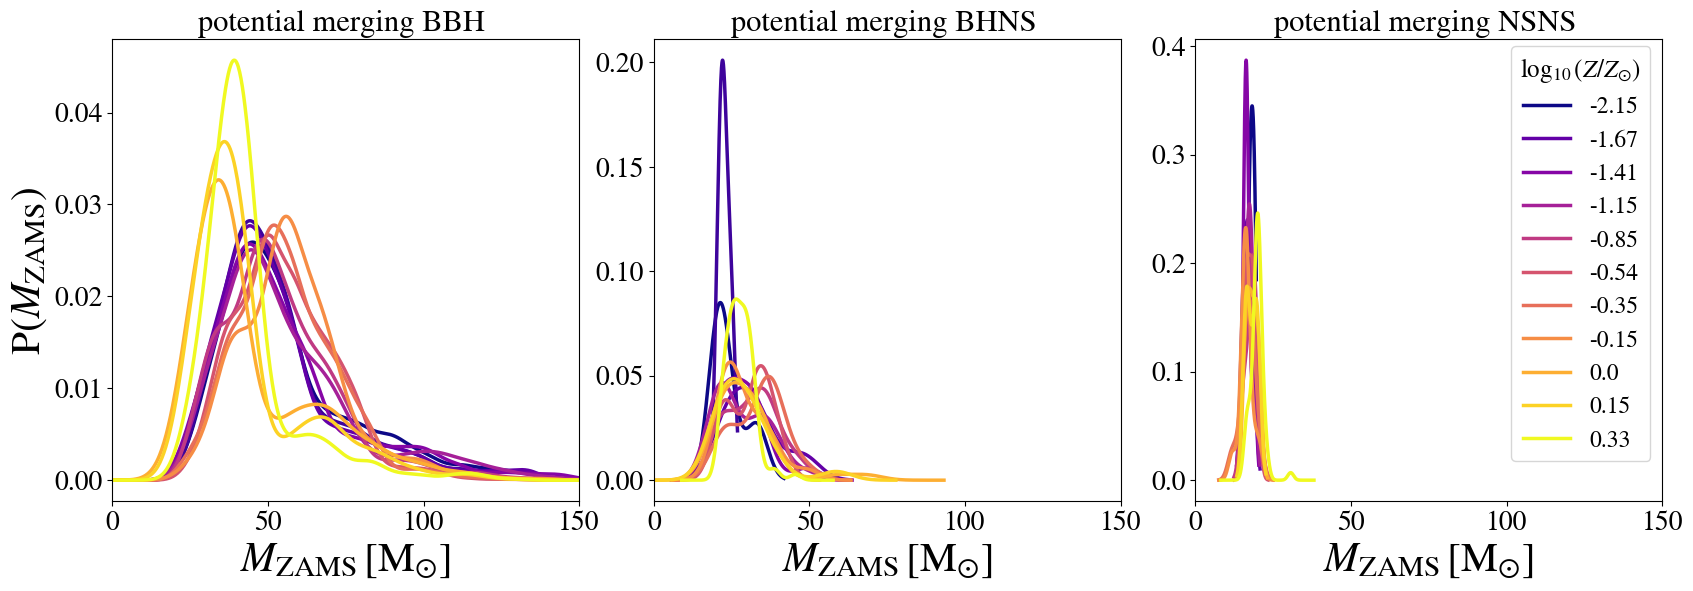

In [58]:
# get a list of colors
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, len(potential_DCO_progenitors['Metallicity@ZAMS(1)'].unique())) )

###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# List of panda tables of pot DCO progenitors
DCO_flavors = ["BBH", "BHNS", "NSNS"]
dfs         = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):
    print(flavor)

    # select the right dataframe
    table       = dfs[DCO_flavors.index(flavor)]
    # focus on systems that actually make a merging DCO
    dco_bool    = DCO_merger_bool(table, flavor = flavor)
    table       = table[dco_bool]

    print('len(table)', len(table))

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    # perform the KDE for each metallicity
    for i, (metal, group) in enumerate(grouped_byZ):
        try:
            group['Mass@ZAMS(1)'].plot.kde(ax=ax, label=f'{np.round(np.log10(metal/0.014), 2)}', color = colors[i], linewidth=2.5)
        except:
            print('error, probably empty group', name, len(group))
            pass

    ax.set_title(f'potential merging {flavor} ', fontsize = 22)

    ax.set_xlim(0,150)
    ax.set_xlabel('$M_{\mathrm{ZAMS}} \, [\mathrm{M_{\odot}}$]', fontsize = 30)
    ax.set_ylabel('')

#########################
# plotvalues
fig.subplots_adjust(hspace=0, wspace=0.16)
axes[0].set_ylabel("P($M_{\mathrm{ZAMS}}$)", fontsize =30)

axes[2].legend(bbox_to_anchor=(1, 1.01), loc='upper right', fontsize = 17, title_fontsize = 18, title = '$\log_{10}(Z/Z_{\odot})$')

plt.savefig(f'../plots/{compas_v}/M_ZAMS_dist{sim_name}.pdf', bbox_inches='tight')
plt.show()

